# Librairies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import contextlib

import sys
sys.path.append('/home/onyxia/work/Macroeconometrics')
from src.preprocessing import apply_transformation

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

#  Data

In [3]:
#Main data
fred_md = pd.read_csv("/home/onyxia/work/Macroeconometrics/data/fred_md_2024_12.csv")
#Metadata
fred_info = pd.read_csv("/home/onyxia/work/Macroeconometrics/data/FRED_MD_updated_appendix.csv", encoding="latin1")
#Recession variable
us_rec = pd.read_csv("/home/onyxia/work/Macroeconometrics/data/USREC.csv")
#Sparse factors data
factors = pd.read_csv('/home/onyxia/work/Macroeconometrics/data/estimated_factor.csv', index_col='sasdate') 

# Data Processing

We construct the dataset by taking all the variables from 1960 to 2024 and applying the transformations indicated in the metadata

In [4]:
#Indexing the dataset with dates
fred_md_short = (
    fred_md.iloc[1:]
    .assign(sasdate=pd.to_datetime(fred_md.iloc[1:].sasdate, format="%m/%d/%Y"))
    .set_index("sasdate")
)

#Transformation of series based on metadata
for _, row in fred_info.iterrows():
    series_name = row['fred']
    transformation_code = row['tcode']

    with contextlib.suppress(Exception):
        fred_md_short[series_name] = apply_transformation(fred_md_short[series_name], transformation_code)

#Filtering data by date
start_date = "1960"
end_date = "2024"
fred_md_short = fred_md_short[
    (fred_md_short.index >= start_date) & (fred_md_short.index <= end_date)
].dropna(axis=1)

#Addition of the variable of interest (American recession)
us_rec = us_rec.assign(
    observation_date=pd.to_datetime(us_rec.observation_date)
).set_index("observation_date")
us_rec = us_rec.loc[fred_md_short.index,:]

# PCA

We represent the number of principal components as a function of the explained variance. Then we construct three datasets using PCA by taking 60%, 80% and 90% of explained variance

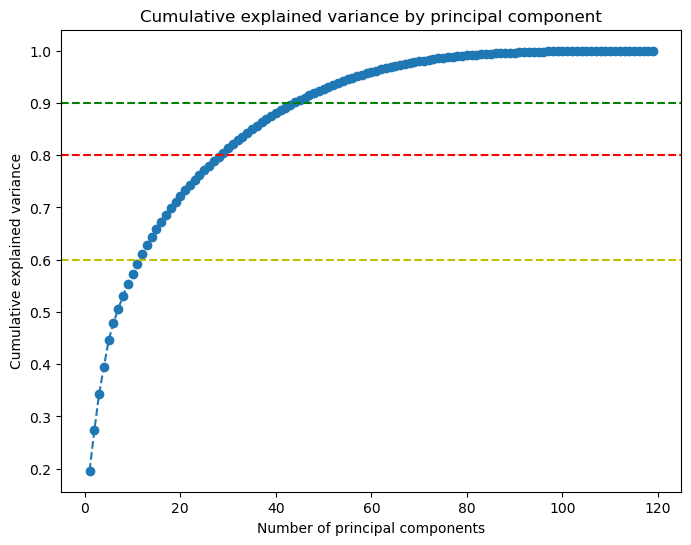

Number of components for 60% explained variance : 12
Number of components for 80% explained variance : 29
Number of components for 90% explained variance : 44


In [5]:
#Normalization of data
scaler = StandardScaler()
fred_md_scaled = scaler.fit_transform(fred_md_short)

#Apply PCA without specifying the number of components (to obtain all components)
pca = PCA()
pca.fit(fred_md_scaled)

#Calculate the variance explained by each component
explained_variance = pca.explained_variance_ratio_

#Plot cumulative explained variance
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title("Cumulative explained variance by principal component")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.axhline(y=0.60, color='y', linestyle='--')  #Line for 60% variance explained
plt.axhline(y=0.80, color='r', linestyle='--')  #Line for 80% variance explained
plt.axhline(y=0.90, color='g', linestyle='--')  #Line for 90% variance explained
plt.show()

# Find the number of components for 60%, 80%, and 90% explained variance
optimal_components_60 = (cumulative_variance >= 0.60).argmax() + 1
optimal_components_80 = (cumulative_variance >= 0.80).argmax() + 1
optimal_components_90 = (cumulative_variance >= 0.90).argmax() + 1
print(f"Number of components for 60% explained variance : {optimal_components_60}")
print(f"Number of components for 80% explained variance : {optimal_components_80}")
print(f"Number of components for 90% explained variance : {optimal_components_90}")

In [6]:
# Apply PCA with these numbers of components
pca_60 = PCA(n_components=optimal_components_60)
pca_80 = PCA(n_components=optimal_components_80)
pca_90 = PCA(n_components=optimal_components_90)

# Transform data with these PCAs
pca_60_components = pca_60.fit_transform(fred_md_scaled)
pca_80_components = pca_80.fit_transform(fred_md_scaled)
pca_90_components = pca_90.fit_transform(fred_md_scaled)

# Convert results to DataFrame
pca_60_df = pd.DataFrame(pca_60_components, columns=[f'PC{i+1}' for i in range(optimal_components_60)])
pca_80_df = pd.DataFrame(pca_80_components, columns=[f'PC{i+1}' for i in range(optimal_components_80)])
pca_90_df = pd.DataFrame(pca_90_components, columns=[f'PC{i+1}' for i in range(optimal_components_90)])

# Put the 'date' index for each PCA DataFrame
pca_60_df.index = fred_md_short.index
pca_80_df.index = fred_md_short.index
pca_90_df.index = fred_md_short.index

# Save each merged DataFrame as a CSV file, keeping the index
#pca_60_df.to_csv('/home/onyxia/work/Macroeconometrics/data/PCA/pca_60.csv', index=True)
#pca_80_df.to_csv('/home/onyxia/work/Macroeconometrics/data/PCA/pca_80.csv', index=True)
#pca_90_df.to_csv('/home/onyxia/work/Macroeconometrics/data/PCA/pca_90.csv', index=True)

# Random Forest

We construct a function which takes as input the covariates X and the variable of interest y and which tunes the hyperparameters by cross-validation, then which trains the best model and which gives us metrics on the classification of the test sample

In [7]:
#Function Random Forest
def run_random_forest(X, y, param_grid=None, test_size=0.2, random_state=667, cv_folds=5):
    """
    Perform Random Forest classification with hyperparameter tuning using GridSearchCV.

    Parameters:
    X : Covariates (features) for training the model.
    y : Target variable for classification.
    param_grid : Dictionary of hyperparameters to tune.
    test_size : Fraction of data to use for testing (default is 0.2).
    random_state : Random seed for reproducibility (default is 42).
    cv_folds : Number of folds for cross-validation (default is 5).
    
    Returns:
    dict: Contains 'best_params', 'classification_report', 'accuracy', and 'feature_importance'.
    """
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state, stratify = y)
    
    # Instantiate Random Forest model
    rf = RandomForestClassifier(random_state=random_state)
    
    # Hyperparameter tuning
    if param_grid is None:
        param_grid = {
        'n_estimators': [1000],  # Number of trees in the forest
        'max_depth': [None, 10, 30],   #Maximum tree depth
        'min_samples_split': [2, 5, 10],   #Minimum number of samples to split a node 
        'min_samples_leaf': [1, 4],     #Minimum number of samples per leaf 
        }
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv_folds, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    #Best model
    best_rf = grid_search.best_estimator_

    #Predictions on the test set
    y_pred = best_rf.predict(X_test)

    #Evaluation
    classification_rep = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    #Feature importance
    importances = best_rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns if isinstance(X, pd.DataFrame) else [f'PC{i+1}' for i in range(X.shape[1])],
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Return results
    return {
        'best_params': grid_search.best_params_,
        'classification_report': classification_rep,
        'accuracy': accuracy,
        'feature_importance': feature_importance_df
    }

## Random Forest with all covariates

In [8]:
#We use the data in t-1 to predict a recession in t
fred_md_lagged = fred_md_short.shift(1)

#Merge lagged data with recession indicator
data = pd.concat([fred_md_lagged, us_rec], axis=1)

#Define variables X (features) and y (target)
X = data.drop(columns=['USREC'])  # Tout sauf 'us_rec' sera utilisé comme caractéristiques
y = data['USREC']  # La variable cible est 'us_rec'

#Run Random Forest with the custom function
results = run_random_forest(X, y)

# Display the results 
print("Best Hyperparameters :", results['best_params'])
print("\nClassification Report:")
print(results['classification_report'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       135
           1       0.80      0.63      0.71        19

    accuracy                           0.94       154
   macro avg       0.87      0.80      0.83       154
weighted avg       0.93      0.94      0.93       154



## Random Forest with PCA

In [9]:
#PCA datasets
pca_60_df = pd.read_csv('/home/onyxia/work/Macroeconometrics/data/PCA/pca_60.csv', index_col='sasdate')  # For 60% variance explained
pca_80_df = pd.read_csv('/home/onyxia/work/Macroeconometrics/data/PCA/pca_80.csv', index_col='sasdate')  # For 80% variance explained
pca_90_df = pd.read_csv('/home/onyxia/work/Macroeconometrics/data/PCA/pca_90.csv', index_col='sasdate')  # For 90% variance explained

pca_60_df.index = pd.to_datetime(pca_60_df.index)
pca_80_df.index = pd.to_datetime(pca_80_df.index)
pca_90_df.index = pd.to_datetime(pca_90_df.index)

In [10]:
#We use the data in t-1 to predict a recession in t
pca_60_df = pca_60_df.shift(1)

#Merge lagged data with recession indicator
pca_60_df = pd.concat([pca_60_df, us_rec], axis=1, join='inner').dropna()

# Target variable is 'USREC', the recession indicator
X_60 = pca_60_df.drop(columns=['USREC'])
y_60 = pca_60_df['USREC']

#Run Random Forest with the custom function
results_60 = run_random_forest(X_60, y_60)

# Display the results for 60% explained variance
print("Best Hyperparameters for 60% Variance Explained:", results_60['best_params'])
print("\nClassification Report for 60% Variance Explained:")
print(results_60['classification_report'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters for 60% Variance Explained: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}

Classification Report for 60% Variance Explained:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       135
           1       0.92      0.58      0.71        19

    accuracy                           0.94       154
   macro avg       0.93      0.79      0.84       154
weighted avg       0.94      0.94      0.94       154



In [11]:
#We use the data in t-1 to predict a recession in t
pca_80_df = pca_80_df.shift(1)

#Merge lagged data with recession indicator
pca_80_df = pd.concat([pca_80_df, us_rec], axis=1, join='inner').dropna()

# Target variable is 'USREC', the recession indicator
X_80 = pca_80_df.drop(columns=['USREC'])
y_80 = pca_80_df['USREC']

# Run Random Forest with the custom function
results_80 = run_random_forest(X_80, y_80)

# Display the results for 80% explained variance
print("Best Hyperparameters for 80% Variance Explained:", results_80['best_params'])
print("\nClassification Report for 80% Variance Explained:")
print(results_80['classification_report'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters for 80% Variance Explained: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}

Classification Report for 80% Variance Explained:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       135
           1       0.90      0.47      0.62        19

    accuracy                           0.93       154
   macro avg       0.92      0.73      0.79       154
weighted avg       0.93      0.93      0.92       154



In [12]:
#We use the data in t-1 to predict a recession in t
pca_90_df = pca_90_df.shift(1)

#Merge lagged data with recession indicator
pca_90_df = pd.concat([pca_90_df, us_rec], axis=1, join='inner').dropna()

# Target variable is 'USREC', the recession indicator
X_90 = pca_90_df.drop(columns=['USREC'])
y_90 = pca_90_df['USREC']

# Run Random Forest with the custom function
results_90 = run_random_forest(X_90, y_90)

# Display the results for 90% explained variance
print("Best Hyperparameters for 90% Variance Explained:", results_90['best_params'])
print("\nClassification Report for 90% Variance Explained:")
print(results_90['classification_report'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters for 90% Variance Explained: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}

Classification Report for 90% Variance Explained:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       135
           1       0.90      0.47      0.62        19

    accuracy                           0.93       154
   macro avg       0.92      0.73      0.79       154
weighted avg       0.93      0.93      0.92       154



## Random Forest with sparse factors

In [13]:
factors.index = pd.to_datetime(factors.index)

#We use the data in t-1 to predict a recession in t
factors = factors.shift(1)

#Merge lagged data with recession indicator
factors = pd.concat([factors, us_rec], axis=1, join='inner').dropna()

# Target variable is 'USREC', the recession indicator
X_factors = factors.drop(columns=['USREC'])
y_factors = factors['USREC']

# Run Random Forest with the custom function
results_factors = run_random_forest(X_factors, y_factors)

# Display the results 
print("Best Hyperparameters:", results_factors['best_params'])
print("\nClassification Report:")
print(results_factors['classification_report'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       135
           1       0.80      0.63      0.71        19

    accuracy                           0.94       154
   macro avg       0.87      0.80      0.83       154
weighted avg       0.93      0.94      0.93       154



In [14]:
#We combine the sparse factors with all the covariates (fred_md_short)
factors = pd.read_csv('/home/onyxia/work/Macroeconometrics/data/estimated_factor.csv', index_col='sasdate') 
factors.index = pd.to_datetime(factors.index)
data = pd.merge(factors, fred_md_short, left_index=True, right_index=True, how='inner')

#We use the data in t-1 to predict a recession in t
data = data.shift(1)

#Merge lagged data with recession indicator
data = pd.concat([data, us_rec], axis=1, join='inner').dropna()

# Target variable is 'USREC', the recession indicator
X = data.drop(columns=['USREC'])
y = data['USREC']

# Run Random Forest with the custom function
results = run_random_forest(X, y)

# Display the results 
print("Best Hyperparameters:", results['best_params'])
print("\nClassification Report:")
print(results['classification_report'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       135
           1       0.85      0.58      0.69        19

    accuracy                           0.94       154
   macro avg       0.89      0.78      0.83       154
weighted avg       0.93      0.94      0.93       154

